## A Geology Flaneur needs an Agentic Companion

Imagine a traveler wearing **Apple Vision Pro**, moving through mountain corridors as a true **geology flaneur**: observing roadcuts, folds, and landforms in context, with grounded explanations layered into the moment.

This notebook is the proof path toward that experience: route-aware field guidance, citation-backed answers, and quality-gated reasoning that can later power an immersive spatial interface.

<img src="../docs/banner-intro-image.png" alt="Banner Intro" style="display:block; margin: 0.35rem auto 0.75rem auto; width: 82%; max-width: 980px; height: auto;"/>

# ANC: Wikipedia + FAISS + Databricks + StateGraph

This notebook combines two Databricks workflows in one place:

- Baseline notebook pipeline: Wikipedia -> chunking -> FAISS -> Databricks-hosted Q&A with `ChatDatabricks`
- Canonical orchestration diagram + run flow via shared `naturalist_companion.stategraph_shared`


## POC Motivation and Evidence

### Why this notebook exists
This notebook is the Databricks proof-of-concept for route-grounded geology guidance.
It validates grounded retrieval + generation + quality checks before full app productionization.

### Hypotheses under test
1. Databricks-hosted embeddings and LLM endpoints can produce useful grounded answers.
2. Wikipedia-only retrieval can support safety-aware field guidance with citations.
3. Shared orchestration (`stategraph_shared`) can enforce quality gates and stable output structure.

### Latest measured run (February 6, 2026)
- Dependency install cell: 39.85s (one-time setup overhead; avoid in steady-state runs)
- Stage 1 load: 4.80s
- Stage 2 chunk/embed/index: 1.65s (14 chunks, 2 embedding batches)
- Stage 3 single answer: 4.29s
- Stage 3b five questions: 19.41s
- StateGraph eval harness (20 questions): 100% pass, 100% citation validity

### What this run does not prove yet
- Multi-user serving scale and concurrency behavior
- Persistent shared retrieval indexes for app traffic
- End-to-end mobile app integration with route + camera UX
- Production SLO/cost governance


## Prerequisites (Run First)

### Databricks setup

- Open this notebook from a Databricks Repo synced to this project.
- Ensure your selected model serving endpoints are available and your user has `Can Query` permission.
- Optional endpoint overrides:
  - `DATABRICKS_EMBEDDING_ENDPOINT`
  - `DATABRICKS_LLM_ENDPOINT`

### Optional notebook installs

Databricks Runtime 17.3 LTS already includes `numpy`, `typing_extensions`, `ipywidgets`, and `jupyterlab-widgets`.
Only run the install cell below if preflight reports missing packages.


In [109]:
from pyspark.sql import SparkSession, DataFrame

def get_spark() -> SparkSession:
  try:
    from databricks.connect import DatabricksSession
    return DatabricksSession.builder.getOrCreate()
  except ImportError:
    return SparkSession.builder.getOrCreate()

In [110]:
import importlib
import json
import re
import os
import sys
from pathlib import Path
from typing import Literal
import warnings
from threading import Event, Thread
from IPython.display import Image, Markdown, display
from time import perf_counter

import mlflow
mlflow.langchain.autolog()


### Dependency Preflight (Fail Fast)

In [111]:
def _candidate_src_paths():
    candidates = []

    # Optional explicit override.
    env_src = os.environ.get("NATURALIST_COMPANION_SRC", "").strip()
    if env_src:
        candidates.append(Path(env_src))

    # Databricks-only overrides are centralized in the Databricks-only setup cell.
    dbx_repo_src = str(globals().get("DBX_REPO_SRC_PATH", "") or "").strip()
    if dbx_repo_src:
        candidates.append(Path(dbx_repo_src))

    cwd = Path.cwd()
    candidates.extend([
        cwd / "src",
        cwd.parent / "src",
        cwd.parent.parent / "src",
    ])

    repos_root = globals().get("DBX_REPOS_ROOT", Path("/Workspace/Repos"))
    repos_root = Path(str(repos_root))
    if repos_root.exists():
        for pkg_dir in repos_root.glob("*/*/src/naturalist_companion"):
            candidates.append(pkg_dir.parent)

    deduped = []
    seen = set()
    for item in candidates:
        key = str(item)
        if key in seen:
            continue
        seen.add(key)
        deduped.append(item)
    return deduped


for src_path in _candidate_src_paths():
    if (src_path / "naturalist_companion").exists() and str(src_path) not in sys.path:
        sys.path.insert(0, str(src_path))
        break


CHECKS = [
    ("FAISS backend", ["faiss"]),
    ("LangGraph runtime", ["langgraph"]),
    ("Wikipedia loader module", ["langchain_community.document_loaders", "langchain.document_loaders"]),
    ("Text splitter module", ["langchain_text_splitters", "langchain.text_splitter"]),
    ("LangChain vectorstore module", ["langchain_community.vectorstores"]),
    ("LangChain in-memory docstore module", ["langchain_community.docstore.in_memory"]),
    ("Databricks integration", ["databricks_langchain"]),
    ("Naturalist stategraph module", ["naturalist_companion.stategraph_shared"]),
]
resolved = {}
missing = []

for label, module_candidates in CHECKS:
    matched = None
    last_error = None
    for module_name in module_candidates:
        try:
            importlib.import_module(module_name)
            matched = module_name
            break
        except ImportError as import_error:
            last_error = f"{type(import_error).__name__}: {import_error}"

    if matched is not None:
        resolved[label] = matched
    else:
        missing.append((label, module_candidates, last_error))

if missing:
    non_stategraph_missing = [m for m in missing if m[0] != "Naturalist stategraph module"]
    if non_stategraph_missing:
        missing = non_stategraph_missing

    lines = ["[preflight] Missing required notebook dependencies:"]
    for label, module_candidates, last_error in missing:
        lines.append(f"- {label}: expected one of {', '.join(module_candidates)}")
        if last_error:
            lines.append(f"  last error: {last_error}")

    lines.append("")
    lines.append("Run the install cell above, restart the kernel, and retry.")
    lines.append("Install hint: %pip install -q -U -r ../requirements-dbrx-notebook.txt")
    lines.append("Set NATURALIST_COMPANION_SRC (or DBX_REPO_SRC_PATH in the Databricks-only cell) if needed.")
    raise ModuleNotFoundError("\n".join(lines))

print("[preflight] Dependency check passed.")
for label, module_name in resolved.items():
    print(f"  - {label}: {module_name}")


[preflight] Dependency check passed.
  - FAISS backend: faiss
  - LangGraph runtime: langgraph
  - Wikipedia loader module: langchain_community.document_loaders
  - Text splitter module: langchain_text_splitters
  - LangChain vectorstore module: langchain_community.vectorstores
  - LangChain in-memory docstore module: langchain_community.docstore.in_memory
  - Databricks integration: databricks_langchain
  - Naturalist stategraph module: naturalist_companion.stategraph_shared


### Notebook Imports + Runtime Config

In [112]:
# Mitigate common macOS OpenMP duplicate-library crashes in notebook kernels.
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

# Silence noisy tqdm widget warning in IDE notebooks when rich progress widgets are unavailable.
warnings.filterwarnings("ignore", message=".*IProgress not found.*")


# LangChain moved WikipediaLoader in newer releases; keep backward compatibility.
try:
    from langchain_community.document_loaders import WikipediaLoader
except ImportError:
    from langchain.document_loaders import WikipediaLoader

try:
    from langchain_text_splitters import RecursiveCharacterTextSplitter
except ImportError:
    from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain_community.vectorstores import FAISS
from databricks_langchain import ChatDatabricks, DatabricksEmbeddings


def _start_heartbeat(task_label: str, every_s: float = 8.0):
    stop = Event()

    def _run():
        elapsed = 0.0
        while not stop.wait(every_s):
            elapsed += every_s
            print(f"[{task_label}] still running... {elapsed:.0f}s elapsed")

    thread = Thread(target=_run, daemon=True)
    thread.start()
    return stop


from naturalist_companion.wikipedia_tools import display_openstreetmap_for_pages, display_wikipedia_images_for_pages

try:
    from langchain_core.documents import Document
except ImportError:
    from langchain.schema import Document

from naturalist_companion.fallback_data import fallback_wiki_pages


STATEGRAPH_AVAILABLE = False
_stategraph_import_error = None
try:
    from naturalist_companion.stategraph_shared import (
        build_stategraph_app,
        run_i81_eval_harness,
        run_stategraph,
    )
    STATEGRAPH_AVAILABLE = True
except Exception as stategraph_import_error:
    _stategraph_import_error = stategraph_import_error
    print(f"[stategraph] import error: {type(stategraph_import_error).__name__}: {stategraph_import_error}")
    print("[stategraph] StateGraph cells can be skipped until this import works.")


def _show_databricks_auth_status() -> None:
    host = os.environ.get("DATABRICKS_HOST", "").strip()
    has_token = bool(os.environ.get("DATABRICKS_TOKEN", "").strip())
    in_runtime = bool(os.environ.get("DATABRICKS_RUNTIME_VERSION", "").strip())

    if in_runtime:
        print("[env] Databricks runtime detected; workspace auth should be available via runtime context.")
        return

    if host and has_token:
        print(f"[env] Databricks auth env detected: DATABRICKS_HOST={host}")
    else:
        print("[env] Databricks auth env not fully set. For local runs set DATABRICKS_HOST and DATABRICKS_TOKEN.")


def _raise_databricks_hint(stage: str, endpoint: str, error: Exception) -> None:
    message = str(error)
    hints = [
        f"[{stage}] Databricks call failed for endpoint={endpoint!r}.",
        f"Underlying error: {message}",
    ]

    lower_msg = message.lower()
    if "invalid access token" in lower_msg or "403" in lower_msg:
        hints.append("Check that DATABRICKS_TOKEN is valid and matches DATABRICKS_HOST.")
        hints.append("In Free Edition, regenerate a PAT and retry if the old token is expired.")
    if "resource_does_not_exist" in lower_msg or "404" in lower_msg:
        hints.append("Verify the endpoint name in Databricks Serving and update notebook env overrides.")
    if "permission" in lower_msg or "can query" in lower_msg:
        hints.append("Ensure your user/token has Can Query permission on the endpoint.")

    raise RuntimeError("\n".join(hints)) from error


_show_databricks_auth_status()


[env] Databricks auth env not fully set. For local runs set DATABRICKS_HOST and DATABRICKS_TOKEN.


### Config (Define LLMs, Embeddings, Vector Store, Data Loader specs)

In [113]:
# DataLoader Config
query_terms = [
    "roadcut",
    "geology",
    "sedimentary rock",
    "stratigraphy",
]
max_docs = 12  # Realistic retrieval setting for richer context.

# Stage 2 chunking + batching controls (keep small for interactive runs).
chunk_size = 1200
chunk_overlap = 150
embedding_batch_size = 4


# Retriever Config
k = 4
EMBEDDING_MODEL_ENDPOINT = os.environ.get("DATABRICKS_EMBEDDING_ENDPOINT", "databricks-bge-large-en")


# LLM Config
LLM_ENDPOINT_NAME = os.environ.get("DATABRICKS_LLM_ENDPOINT", "databricks-meta-llama-3-1-8b-instruct")
TEMPERATURE = 0.625


# Response style controls (Roadside Geology audience: curious drivers, practical field learners).
RESPONSE_TONE = "field-guide"
MAX_BULLETS_PER_SECTION = 3


# Local artifact settings
FAISS_NAMESPACE = "anc_dbrx"


# StateGraph Config
STATEGRAPH_PROVIDER: Literal["databricks"] = "databricks"
STATEGRAPH_LIVE_MAX_DOCS = 16
STATEGRAPH_COMMON_CONFIG = {
    "max_retrieval_attempts": 3,
    "citation_coverage_threshold": 0.80,
    "runtime_mode": "realistic",
    "llm_temperature": TEMPERATURE,
    "llm_model": LLM_ENDPOINT_NAME,
    "live_max_docs": STATEGRAPH_LIVE_MAX_DOCS,
}
STATEGRAPH_RUN_CONFIG = {"artifact_root": "out/stategraph/notebook_runs", **STATEGRAPH_COMMON_CONFIG}
STATEGRAPH_EVAL_CONFIG = {"artifact_root": "out/stategraph/notebook_eval", **STATEGRAPH_COMMON_CONFIG}


## Query Prompt (Edit This Cell)

Use the next code cell to set the active question(s).

Question types this notebook is designed for:
- Detour geology: legal pull-offs or short walks near a route segment
- Safety-first prompts: where to stop and what to avoid roadside
- Route constraints: city/exit anchors plus max detour minutes
- Beginner field interpretation: what visual clues to look for and why they matter

Tip: Include your nearest city or exit and your max detour time to improve stop recommendations.


In [114]:
example_question = "Near I-81 between Winchester and Strasburg, where can I safely stop to see Valley-and-Ridge structure, and what field clues confirm folding?"

example_questions = [
    "I am driving I-81 near Bristol, TN. Give me two legal pull-off stops where I can see clear sedimentary layering, and tell me exactly what to look for.",
    "I am on I-81 near Hagerstown with a 30-minute detour. Where can I safely stop to observe folded Valley-and-Ridge strata, and what exactly should I look for?",
    "I have 45 minutes near Hagerstown, MD. What roadside geology stop gives the best payoff for a beginner, and what story does the outcrop tell?",
    "On an I-81 drive day, suggest one stop where I can observe evidence of ancient seas or sediment transport, with specific visual clues.",
]

# StateGraph run can use the same prompt by default; edit independently if desired.
stategraph_question = example_question

def _parse_place_query_list(raw: str, max_items: int = 6) -> list[str]:
    text = str(raw or "").strip()
    if not text:
        return []
    match = re.search(r"\[[\s\S]*\]", text)
    if match:
        text = match.group(0)
    try:
        data = json.loads(text)
    except json.JSONDecodeError:
        data = [ln.strip(" -•	") for ln in text.splitlines() if ln.strip()]

    out: list[str] = []
    for item in data if isinstance(data, list) else []:
        value = str(item or "").strip()
        if not value:
            continue
        low = value.lower()
        if any(token in low for token in ("interstate", "highway", "i-81", "route ")):
            continue
        if value not in out:
            out.append(value)
        if len(out) >= int(max_items):
            break
    return out


def _generate_place_image_queries_with_model(question: str, max_items: int = 6) -> list[str]:
    prompt = (
        "Return only JSON: an array of concise Wikipedia search queries for NATURAL LANDSCAPES "
        "near this route question. Exclude highways, interstates, and city-only queries. "
        "Prefer valleys, ridges, mountains, parks, overlooks, and geologic landforms. "
        f"Question: {question}"
    )
    try:
        planner = ChatDatabricks(endpoint=LLM_ENDPOINT_NAME, temperature=min(0.3, float(TEMPERATURE)))
        response = planner.invoke(prompt)
        raw = getattr(response, "content", response)
        places = _parse_place_query_list(raw, max_items=max_items)
        if places:
            return places
    except Exception as query_error:
        print(f"[query] place query generation fallback: {type(query_error).__name__}: {query_error}")

    return [
        "Shenandoah Valley overlooks",
        "Blue Ridge Mountains viewpoints",
        "Appalachian Valley and Ridge outcrops",
        "Catoctin Mountain Park geology",
        "Great North Mountain ridge overlook",
    ][: max(1, int(max_items))]


place_image_queries = _generate_place_image_queries_with_model(example_question, max_items=6)
print("[query] place_image_queries:")
for query_idx, query_text in enumerate(place_image_queries, start=1):
    print(f"  {query_idx}. {query_text}")


[query] place_image_queries:
  1. *   "Valley-and-Ridge structure near Winchester, VA"
  2. *   "Mountain landforms between Winchester and Strasburg, VA"
  3. *   "Parks with Valley-and-Ridge structure near Winchester, VA"
  4. *   "Ridge landforms near Strasburg, VA with Valley-and-Ridge structure"


### Stage 1/3: Wikipedia Data Load

In [115]:
print("[stage 1/3] Starting document load (real Wikipedia first; fallback on problems)...")
query = " ".join(query_terms) if isinstance(query_terms, list) else query_terms
print(f"[stage 1/3] query={query!r}, max_docs={max_docs}")

docs = []
data_source = "real_wikipedia"
fallback_reason = None

stage1_heartbeat = _start_heartbeat("stage 1/3 wikipedia load", every_s=8.0)
t0 = perf_counter()
try:
    try:
        docs = WikipediaLoader(query=query, load_max_docs=max_docs).load()
    except Exception as load_error:
        fallback_reason = f"{type(load_error).__name__}: {load_error}"
        docs = []
finally:
    stage1_heartbeat.set()
t1 = perf_counter()

if docs:
    data_source = "real_wikipedia"
else:
    data_source = "fallback_data"
    if fallback_reason is None:
        fallback_reason = "WikipediaLoader returned 0 documents."

    pages = fallback_wiki_pages()
    docs = [
        Document(
            page_content=f"{str(page.get('summary') or '').strip()}\n\n{str(page.get('content') or '').strip()}".strip(),
            metadata={
                "title": str(page.get("title") or f"fallback_page_{pageid}"),
                "source": str(page.get("url") or ""),
                "pageid": int(page.get("pageid") or pageid),
                "data_source": "fallback_data",
            },
        )
        for pageid, page in pages.items()
    ]

print(f"[stage 1/3] Loaded {len(docs)} document(s) in {t1 - t0:.2f}s")
print(f"[stage 1/3] data_source={data_source}")
if data_source == "fallback_data":
    print(f"[stage 1/3] FALLBACK ACTIVE: {fallback_reason}")
else:
    print("[stage 1/3] Real Wikipedia data loaded successfully.")

if not docs:
    raise RuntimeError("No documents available from real or fallback data. Check notebook environment and retry.")

print("[stage 1/3] Sample titles:")
for sample_idx, sample_doc in enumerate(docs[:3], start=1):
    sample_title = str((sample_doc.metadata or {}).get("title") or f"doc_{sample_idx}")
    sample_source = str((sample_doc.metadata or {}).get("source") or "n/a")
    print(f"  {sample_idx}. {sample_title} ({sample_source})")

print("[stage 1/3] Wikipedia image previews from loaded pages...")
display_wikipedia_images_for_pages(docs, max_images=min(3, len(docs)), prefer_landscape=True, route_hint=example_question)

print("[stage 1/3] Wikipedia image previews near place queries...")
display_wikipedia_images_for_pages(place_image_queries, max_images=min(5, len(place_image_queries)), prefer_landscape=True, route_hint=example_question)
print("[stage 1/3] OpenStreetMap previews for landscape points...")
display_openstreetmap_for_pages(place_image_queries or docs, max_points=10, prefer_landscape=True, route_hint=example_question)


[stage 1/3] Starting document load (real Wikipedia first; fallback on problems)...
[stage 1/3] query='roadcut geology sedimentary rock stratigraphy', max_docs=12
[stage 1/3 wikipedia load] still running... 8s elapsed
[stage 1/3] Loaded 12 document(s) in 8.59s
[stage 1/3] data_source=real_wikipedia
[stage 1/3] Real Wikipedia data loaded successfully.
[stage 1/3] Sample titles:
  1. Carboniferous (https://en.wikipedia.org/wiki/Carboniferous)
  2. Paleomagnetism (https://en.wikipedia.org/wiki/Paleomagnetism)
  3. Artinskian (https://en.wikipedia.org/wiki/Artinskian)
[stage 1/3] Wikipedia image previews from loaded pages...


**Wikipedia image preview: Carboniferous rainforest collapse**

[Open page](https://en.wikipedia.org/wiki/Carboniferous_rainforest_collapse)

**Wikipedia image preview: Tunnel valley**

[Open page](https://en.wikipedia.org/wiki/Tunnel_valley)

**Wikipedia image preview: Central Pangean Mountains**

[Open page](https://en.wikipedia.org/wiki/Central_Pangean_Mountains)

[stage 1/3] Wikipedia image previews near place queries...
[wiki-images] No thumbnail images found for the selected pages.
[stage 1/3] OpenStreetMap previews for landscape points...
[wiki-map] No mappable Wikipedia coordinates found.


0

### Stage 2/3: Build + Save FAISS Index, Then Retrieve

In [116]:
if "docs" not in globals() or not docs:
    raise RuntimeError("`docs` not found. Run Stage 1/3 first.")

print(f"[stage 2/3] Building embeddings with endpoint={EMBEDDING_MODEL_ENDPOINT!r}...")
print(
    f"[stage 2/3] Chunking docs with chunk_size={chunk_size}, chunk_overlap={chunk_overlap}, "
    f"embedding_batch_size={embedding_batch_size}"
)

splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
split_docs = splitter.split_documents(docs)
if not split_docs:
    raise RuntimeError("Chunking produced 0 documents. Adjust chunk_size/chunk_overlap and retry.")

total_chars = sum(len(str(d.page_content or "")) for d in split_docs)
print(f"[stage 2/3] Prepared {len(split_docs)} chunk(s), total_chars={total_chars}")

embeddings = DatabricksEmbeddings(endpoint=EMBEDDING_MODEL_ENDPOINT)

batch_size = max(1, int(embedding_batch_size))
vector_store = None

stage2_heartbeat = _start_heartbeat("stage 2/3 embedding/index", every_s=8.0)
t2 = perf_counter()
try:
    try:
        for start in range(0, len(split_docs), batch_size):
            batch = split_docs[start : start + batch_size]
            b0 = perf_counter()
            if vector_store is None:
                vector_store = FAISS.from_documents(batch, embeddings)
            else:
                vector_store.add_documents(batch)
            b1 = perf_counter()

            done = min(start + batch_size, len(split_docs))
            pct = (100.0 * done) / len(split_docs)
            print(
                f"[stage 2/3] Embedded batch {start // batch_size + 1}: "
                f"{done}/{len(split_docs)} chunks ({pct:.1f}%) in {b1 - b0:.2f}s"
            )
    except Exception as embedding_error:
        _raise_databricks_hint("stage 2/3 embedding/index", EMBEDDING_MODEL_ENDPOINT, embedding_error)
finally:
    stage2_heartbeat.set()

t3 = perf_counter()
if vector_store is None:
    raise RuntimeError("Vector store was not created.")

print(f"[stage 2/3] Built FAISS index in {t3 - t2:.2f}s")


faiss_base = os.environ.get("ANC_FAISS_DIR", "").strip()
if faiss_base:
    faiss_dir = (Path(faiss_base).expanduser() / FAISS_NAMESPACE).resolve()
else:
    faiss_dir = (Path.home() / "DATA" / "naturalist-companion" / "faiss" / FAISS_NAMESPACE).resolve()

faiss_dir.mkdir(parents=True, exist_ok=True)
vector_store.save_local(str(faiss_dir))
print(f"[stage 2/3] Saved FAISS index to: {faiss_dir}")


print(f"[stage 2/3] Running similarity search for question={example_question!r}, k={k}...")
results = vector_store.similarity_search(example_question, k=k)
print(f"[stage 2/3] Retrieved {len(results)} result(s)")

for result_idx, result_doc in enumerate(results, start=1):
    result_title = str((result_doc.metadata or {}).get("title") or f"result_{result_idx}")
    result_source = str((result_doc.metadata or {}).get("source") or "n/a")
    result_snippet = str(result_doc.page_content or "")[:220].replace("\n", " ")
    print(f"  {result_idx}. {result_title} ({result_source})")
    print(f"     {result_snippet}...")

print("[stage 2/3] Wikipedia image previews from retrieved pages...")
display_wikipedia_images_for_pages(results, max_images=min(4, len(results)))


[stage 2/3] Building embeddings with endpoint='databricks-bge-large-en'...
[stage 2/3] Chunking docs with chunk_size=1200, chunk_overlap=150, embedding_batch_size=4
[stage 2/3] Prepared 56 chunk(s), total_chars=43616
[stage 2/3] Embedded batch 1: 4/56 chunks (7.1%) in 0.61s
[stage 2/3] Embedded batch 2: 8/56 chunks (14.3%) in 0.51s
[stage 2/3] Embedded batch 3: 12/56 chunks (21.4%) in 0.51s
[stage 2/3] Embedded batch 4: 16/56 chunks (28.6%) in 0.60s
[stage 2/3] Embedded batch 5: 20/56 chunks (35.7%) in 0.52s
[stage 2/3] Embedded batch 6: 24/56 chunks (42.9%) in 0.53s
[stage 2/3] Embedded batch 7: 28/56 chunks (50.0%) in 0.35s
[stage 2/3] Embedded batch 8: 32/56 chunks (57.1%) in 0.44s
[stage 2/3] Embedded batch 9: 36/56 chunks (64.3%) in 0.28s
[stage 2/3] Embedded batch 10: 40/56 chunks (71.4%) in 0.62s
[stage 2/3] Embedded batch 11: 44/56 chunks (78.6%) in 0.28s
[stage 2/3] Embedded batch 12: 48/56 chunks (85.7%) in 0.45s
[stage 2/3] Embedded batch 13: 52/56 chunks (92.9%) in 0.50s
[s

**Wikipedia image preview: Keyser Formation**

[Open page](https://en.wikipedia.org/wiki/Keyser_Formation)

**Wikipedia image preview: Cow Branch Formation**

[Open page](https://en.wikipedia.org/wiki/Cow_Branch_Formation)

**Wikipedia image preview: Conococheague Formation**

[Open page](https://en.wikipedia.org/wiki/Conococheague_Formation)

**Wikipedia image preview: Marcellus Formation**

[Open page](https://en.wikipedia.org/wiki/Marcellus_Formation)

4

### Stage 3/3: Generate Answer with ChatDatabricks

In [117]:
if "vector_store" not in globals():
    raise RuntimeError("`vector_store` not found. Run Stage 2/3 first.")

print(f"[stage 3/3] Generating answer with endpoint={LLM_ENDPOINT_NAME!r}...")
llm = ChatDatabricks(endpoint=LLM_ENDPOINT_NAME, temperature=TEMPERATURE)

voice_instructions = f"""
You are writing in a concise Roadside Geology field-guide voice for curious drivers.
Tone:
- Plainspoken, observant, and practical (not academic).
- Emphasize what can be seen from legal/safe pull-offs or short walks.
- Explain key geology in everyday language, then add one precise term when useful.
- Include safety and access realism (do not suggest unsafe roadside behavior).
Output format:
1) "Where to stop" (up to {MAX_BULLETS_PER_SECTION} bullets)
2) "What to look for" (up to {MAX_BULLETS_PER_SECTION} bullets)
3) "Why it matters" (2-4 sentences)
4) "Citations" (Wikipedia URLs only)
""".strip()


def _context_for_question(question: str, top_k: int = 2) -> str:
    local_results = vector_store.similarity_search(question, k=max(1, top_k))
    context_lines: list[str] = []
    for context_idx, context_doc in enumerate(local_results, start=1):
        context_title = str((context_doc.metadata or {}).get("title") or f"result_{context_idx}")
        context_source = str((context_doc.metadata or {}).get("source") or "n/a")
        context_snippet = str(context_doc.page_content or "")[:450].replace("\n", " ")
        context_lines.append(f"[{context_idx}] {context_title} ({context_source}) :: {context_snippet}")
    return "\n".join(context_lines)


def answer_question(question: str) -> str:
    context_block = _context_for_question(question, top_k=max(1, k))
    prompt = (
        f"Use only the provided Wikipedia-grounded context when you can.\n\n"
        f"Question: {question}\n\n"
        f"Context:\n{context_block}\n\n"
        f"Style requirements:\n{voice_instructions}"
    )

    llm_heartbeat = _start_heartbeat("stage 3/3 llm", every_s=8.0)
    started_at = perf_counter()
    llm_response = None
    try:
        try:
            llm_response = llm.invoke(prompt)
        except Exception as llm_error:
            _raise_databricks_hint("stage 3/3 llm", LLM_ENDPOINT_NAME, llm_error)
    finally:
        llm_heartbeat.set()
    dt = perf_counter() - started_at
    print(f"[stage 3/3] LLM response received in {dt:.2f}s")
    if llm_response is None:
        raise RuntimeError("LLM did not return a response.")
    response_content = getattr(llm_response, "content", llm_response)
    return str(response_content)


print(f"[stage 3/3] Primary question:\n- {example_question}")
primary_answer = answer_question(example_question)
print("\nAnswer:\n")
print(primary_answer)


[stage 3/3] Generating answer with endpoint='databricks-meta-llama-3-1-8b-instruct'...
[stage 3/3] Primary question:
- Near I-81 between Winchester and Strasburg, where can I safely stop to see Valley-and-Ridge structure, and what field clues confirm folding?
[stage 3/3] LLM response received in 2.82s

Answer:

**Stop and Explore: Valley-and-Ridge Structure**

**Where to Stop:**

* Safe pull-offs or parking areas along I-81 between Winchester and Strasburg, Virginia
* Consider stopping at the Conococheague Formation's notable exposures along roadcuts near mile marker 20 of I-70 near Hagerstown, Maryland (just off I-81)
* If you have time, visit the Keyser Formation's type section in Keyser, West Virginia, but be prepared for a longer drive

**What to Look For:**

* **Folding of rocks**: Look for areas where the rock layers are bent or folded, often creating a "V" or "S" shape. This is a result of tectonic forces pushing the Earth's crust.
* **Changes in rock type**: Notice how the rock

### Stage 3b/3: Run All Example Questions

In [118]:
if "answer_question" not in globals():
    raise RuntimeError("`answer_question` not found. Run Stage 3/3 first.")

if "example_questions" not in globals() or not example_questions:
    raise RuntimeError("`example_questions` is empty. Check config cell.")

all_answers = []
print(f"[stage 3b/3] Running {len(example_questions)} example question(s)...")

for question_idx, question_text in enumerate(example_questions, start=1):
    print("\n" + "=" * 110)
    print(f"[stage 3b/3] Question {question_idx}/{len(example_questions)}")
    print(question_text)
    print("=" * 110)

    answer_text = answer_question(question_text)
    all_answers.append({"question": question_text, "answer": answer_text})

    print("\nResponse:\n")
    print(answer_text)

print(f"\n[stage 3b/3] Completed {len(all_answers)} question(s).")


[stage 3b/3] Running 4 example question(s)...

[stage 3b/3] Question 1/4
I am driving I-81 near Bristol, TN. Give me two legal pull-off stops where I can see clear sedimentary layering, and tell me exactly what to look for.
[stage 3/3] LLM response received in 2.57s

Response:

**Where to stop:**

* Near the town of Bristol, TN, look for the Bluff City Road exit (exit 69) off I-81. Park in the designated parking area and walk along the nearby rail trail.
* For a more scenic stop, exit I-81 at the Kingsport exit (exit 69) and head to the Bays Mountain Park. Park in the visitor center lot and walk to the park's scenic overlook.

**What to look for:**

* Exposed sedimentary layers in the Marcellus Formation, which will appear as dark grey to black, fine-grained shale and mudstone. Look for the characteristic boxwork texture, which is a result of the dissolution of limestone by acidic groundwater.
* The Conococheague Formation's Upper Cambrian-aged fossils, such as conodonts, may be visibl

## Canonical Workflow Diagram (StateGraph)

StateGraph remains the shared orchestration contract (routing/clarification, retries, quality gate, and final output schema).

### Notebook-only workflow (Databricks)
- Refresh partitioned retrieval indexes in a notebook cell:
  `refresh_retrieval_partitions(config={"store_root": "out/stategraph_store"}, runtime_mode="realistic", partitions=["corridor_i81"], force=False)`
- Run eval harness in a notebook cell:
  `run_i81_eval_harness(provider="databricks", config={"runtime_mode": "realistic", "retrieval_backend": "persistent", "store_root": "out/stategraph_store", "artifact_root": "out/stategraph_eval"})`
- Run release gate in a notebook cell before promotion:
  `run_real_data_release_gate(provider="databricks", config={"runtime_mode": "realistic", "retrieval_backend": "persistent", "store_root": "out/stategraph_store", "artifact_root": "out/stategraph_release_gate"})`
- Use `runtime_mode="deterministic"` when offline or when provider credentials are unavailable.

### Target Architecture (PlantUML)
<img src="../docs/diagrams/rendered/06_anc_databricks_production_app.svg" alt="ANC Databricks Target Architecture" style="display:block; margin: 0.5rem auto; width: 92%; max-width: 1200px; height: auto;"/>

[Open PNG version](../docs/diagrams/rendered/06_anc_databricks_production_app.png)


In [119]:
if STATEGRAPH_AVAILABLE:
    print("[stategraph] Ready: naturalist_companion.stategraph_shared imported in setup cells.")
else:
    display(
        Markdown(
            "**StateGraph module is unavailable in this workspace.**\n\n"
            "Baseline Databricks stages (Wikipedia -> FAISS -> ChatDatabricks) still run.\n\n"
            "If this repo is synced in Databricks Repos, open the notebook from the Repo path "
            "(not a copied workspace file), or set `NATURALIST_COMPANION_SRC` "
            "(or `DBX_REPO_SRC_PATH` in the Databricks-only cell)."
        )
    )
    if _stategraph_import_error is not None:
        print(f"[stategraph] import error: {type(_stategraph_import_error).__name__}: {_stategraph_import_error}")


[stategraph] Ready: naturalist_companion.stategraph_shared imported in setup cells.


### A) CUSTOM LOGIC

__REQUIRED__: This section is where input your custom logic to create and run your agentic workflow. Feel free to add as many codes cells that are needed for this assignment.
PLEASE see the StateGraph image below for the expected orchestration contract.

Compiled StateGraph successfully for provider: databricks


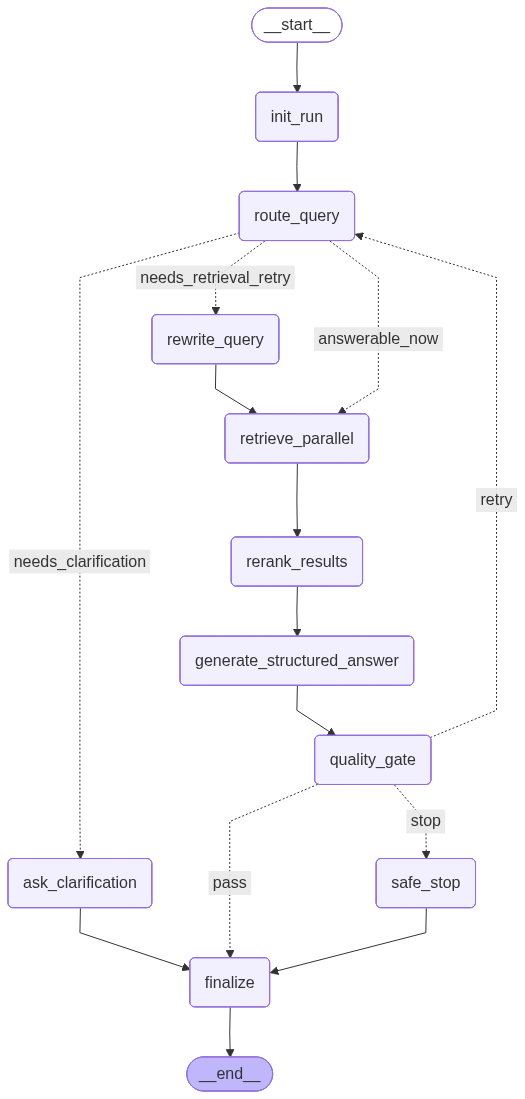

In [120]:
if not STATEGRAPH_AVAILABLE:
    print("[stategraph] Skipping canonical diagram: naturalist_companion not available.")
else:
    provider: Literal["databricks"] = STATEGRAPH_PROVIDER
    app = build_stategraph_app(provider=provider)
    print('Compiled StateGraph successfully for provider:', provider)

    # Render a real image (PNG bytes) instead of plain Mermaid text.
    try:
        png_bytes = app.get_graph().draw_mermaid_png()
        display(Image(data=png_bytes, width=880))
    except Exception as graph_render_error:
        display(Markdown(f'Graph render fallback (text). Error: `{type(graph_render_error).__name__}: {graph_render_error}`'))
        print(app.get_graph().draw_mermaid())


In [121]:
if not STATEGRAPH_AVAILABLE:
    print("[stategraph] Skipping run_stategraph: naturalist_companion not available.")
else:
    result = run_stategraph(
        stategraph_question,
        provider=STATEGRAPH_PROVIDER,
        config=STATEGRAPH_RUN_CONFIG,
    )
    final_output = result['final_output']
    print('Question:', stategraph_question)
    print('Provider:', final_output['provider'])
    print('Route:', final_output['route_decision']['decision'])
    print('Quality passed:', final_output['quality']['passed'])
    quality_reasons = final_output['quality'].get('reasons', [])
    print('Quality reasons:', ', '.join(quality_reasons) if quality_reasons else 'none')
    print('Attempts:', final_output['retrieval_attempts'])
    print('Artifact dir:', result['artifact_dir'])
    print('Response:')
    print(final_output['answer']['response'])
    print('Citation image previews:')
    display_wikipedia_images_for_pages(final_output['answer'].get('citations', []), max_images=4)


Question: Near I-81 between Winchester and Strasburg, where can I safely stop to see Valley-and-Ridge structure, and what field clues confirm folding?
Provider: databricks
Route: needs_retrieval_retry
Quality passed: False
Quality reasons: safe_stop_constraint_failed
Attempts: 3
Artifact dir: out/stategraph/notebook_runs/databricks/run_20260207T002648_3d64874b
Response:
Safe stop: quality gates did not pass after maximum retrieval retries. No final grounded answer was emitted.
Citation image previews:


**Wikipedia image preview: Appalachian Mountains**

[Open page](https://en.wikipedia.org/wiki/Appalachian_Mountains)

**Wikipedia image preview: Interstate 81**

[Open page](https://en.wikipedia.org/wiki/Interstate_81)

In [122]:
if not STATEGRAPH_AVAILABLE:
    print("[stategraph] Skipping eval harness: naturalist_companion not available.")
else:
    report = run_i81_eval_harness(
        provider=STATEGRAPH_PROVIDER,
        config=STATEGRAPH_EVAL_CONFIG,
    )
    print(report['summary'])
    print(report['artifact_root'])


{'provider': 'databricks', 'eval_id': 'eval_20260207T002648Z', 'question_count': 20, 'avg_latency_ms': 99.86, 'median_latency_ms': 101.77, 'citation_validity_pct': 100.0, 'pass_rate_pct': 0.0, 'pass_count': 0, 'fail_count': 20}
/Users/ryan/Developer/naturalist-companion/notebooks/out/stategraph/notebook_eval/databricks/eval_runs/eval_20260207T002648Z


# B) REFLECTION

## 1. If you had more time, which specific improvements or enhancements would you make to your agentic workflow, and why?
- I seriously want this in the iPhone, iPadOS, VisionPro App Store.
- Build an iOS thin client for the 3 core loops (Route Guide / Camera / Explore) wired to the existing `/api/guide` + `/api/vision` contracts/stubs  validates the app experience early without waiting on model perfection.
- Add a next best observation engine (follow-up questions + photo requests driven by uncertainty)  improves calibrated confidence and second-turn success.
- Make one canonical LangGraph run everywhere (local + Vertex + notebook + web) with capability flags  prevents provider drift and keeps the local-first workflow fast.
- Emit per-run trace artifacts (retrieval inputs, sources, node timings, output IDs)  makes debugging and iteration materially faster.
- Expand eval into a real release gate (schema + citation validity + small golden set + latency/cost budgets)  stops regressions while scaling features.
- Tighten grounding from has citations to claimcitation mapping where feasible  makes grounded over clever auditable and more trustworthy.
- Add privacy-first media handling plus offline-friendly caches (photos local by default, explicit opt-in upload, corridor packs)  matches the PRDs trust + on-the-road usability goals.
- Create a vetted-source plugin path (e.g., USGS/field guides) with the same validators/gates  enables Phase 2+ expansion without weakening the Wikipedia-first baseline.
- I will be developing this as a web app for the next few weeks on my Public GitHub: https://github.com/TechR10n/naturalist-companion.

## 2. What concrete steps are required to move this workflow from prototype to production?
- Replace the notebook-only “Wikipedia → FAISS → answer” flow with a production data pipeline that ingests/cleans/chunks sources and writes versioned Delta tables governed by Unity Catalog.
- Build/refresh a Databricks Vector Search index from those UC tables (instead of per-run in-memory FAISS), and tune chunking/filters/re-ranking using retrieval eval metrics.
- Package the orchestration (StateGraph/chain) as an MLflow pyfunc model with pre/post-processing + signature + input examples, register it in Unity Catalog, and deploy via Model Serving / foundation model APIs.
- Use Agent Framework patterns for tool definitions, multi-step reasoning, and consistent I/O schemas so the app can depend on stable contracts (and so evaluation/tracing is first-class).
- Separate offline batch workloads (embedding backfills, index upserts, batch inference via `ai_query`) from low-latency online serving; schedule with Jobs/Workflows.
- Implement governance & access controls end-to-end: service principals, secret scopes, UC permissions on tables/indexes/models, and Model Serving endpoint ACLs.
- Add guardrails for production: prompt-injection defenses, PII masking, safety policies (“legal pull-offs only”), and licensing/attribution checks for ingested sources.
- Create a representative, versioned evaluation dataset (queries + route context + optional images) and define task-specific metrics/rubrics for both retrieval and generation.
- Use a mix of automated evaluation (LLM judges / reference-free metrics) and human review to catch hallucinations, unsafe guidance, and domain nuance; calibrate judges to your rubric.
- Gate releases on eval + operational budgets: block promotion if quality/citation-validity/safety regress or if latency/cost budgets are breached.
- Turn on production observability: MLflow tracing, inference logging + inference tables, and Agent Monitoring to track quality/latency/cost/drift over time.
- Return app-ready structured outputs (JSON stop cards, citations, uncertainty/clarification route) instead of notebook-formatted text; enforce via prompt + schema validation.
